# Task 1
QOSF screening tasks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RXGate, RZGate
from qiskit import Aer
from qiskit import execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import itertools

In [2]:
#4 Qubit quantum circuit for the green even blocks
#Curious about scaling up to bigger circuit i.e. larger n



def Even_block(qc,theta_list):
    ''' 
     Args:
        theta_list: list of z-axis rotations.
        #Need to accomodate for array as well
        
        qc: Input circuit

     Returns:
        Circuit after unitary evolution
    '''
    #if type(theta_list)=='nd.array'
    #For now, to remove amb: use 4 instead
    
    for i in range(4):
        # i is the qubit index now 
        qc.rz(theta_list[i], i)
    
    #Double gates are cz gates for even blocks 
    for pair in itertools.combinations([0,1,2,3],2):
        #print(pair)
        qc.cz(pair[0],pair[1])
    

    return qc



In [3]:
def Odd_block(qc,theta_list):
    
    ''' 
     Args:
        theta_list: list of x-axis rotations.
        Length 
        qc: Input circuit

     Returns:
        Circuit after unitary evolution
    '''

    
    #Double gates are cx gates for even blocks 
    for i in range(len(theta_list)):

        qc.rx(theta_list[i], i)
    


    return qc


# Initialization

In [4]:
n_qubits=4
qr = QuantumRegister(n_qubits)
cr = ClassicalRegister(n_qubits)
base_circuit = QuantumCircuit(qr, cr)


In [5]:
#Initialize variational parameters
theta_list_even=np.random.uniform(0,2*np.pi,n_qubits)
#theta_list_even

theta_list_odd=np.random.uniform(0,2*np.pi,n_qubits)
#theta_list_odd


# Minimum Distance 
First define a distance function <br>
Then study the variations so as to report the minimum for a fixed L <br>




In [6]:
#print(random_statevector(4))

def Norm(psi, Phi):

    ''' 
     Args:
        Phi: A random state with the dimensions of the state.
        Psi: Input state

     Returns:
        L2 norm of the difference of the two state
    '''
    return np.sum(np.square(np.abs(psi-Phi)))
       

 To find right set of variational parameters using grid search 
 or gradient descent


Since the parameter space of grid search is too large and hence for multilayers will take a long time, is it a better idea to do a gradient search? <br>

# Gradient Descent
Starting with single layer

In [19]:
theta_par_array=np.random.uniform(0,2*np.pi,8)


In [20]:
# We need to define Norm incorporating its computing 
# Let's call it as the objective now to avoid confusion
Phi=random_statevector(2**n_qubits, seed=100).data

#Implements the entire cost function on the quantum circuit

def Objective_fn(params, layers=None):
    ''' 
     Args:
        
        params: Parameters are basically the list of thetas 
     
     Returns:
        Value of the norm for the set of parameters
    '''    

    #Since Phi is a constant, we have removed to avoid confusion
    #Psi: This is computed in here

    #Beginning with single layer
    #theta_list_even=[theta_1,theta_2,theta_3,theta_4]

    #theta_list_odd=[theta_5,theta_6,theta_7,theta_8]
    n_qubits=4
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    base_circuit = QuantumCircuit(qr, cr)


    base_circuit=Even_block(base_circuit,params[0:n_qubits])

    base_circuit=Odd_block(base_circuit,params[n_qubits:2*n_qubits])

    backend = Aer.get_backend('statevector_simulator')

    job = execute(base_circuit, backend)

    result = job.result()
    outputstate = result.get_statevector(base_circuit, decimals=3)

    #error_list.append(Norm(outputstate, Phi))

    return Norm(outputstate, Phi)

# Using AQGD (QISKIT)

In [21]:
from qiskit.aqua.components.optimizers import AQGD, ADAM
#Analytic Quantum Gradient Descent (AQGD) optimizer.
#But we might have issues here

In [22]:
print(type(theta_par_array))
print(theta_par_array[0:4])

<class 'numpy.ndarray'>
[0.43766364 3.52292164 4.28312898 1.44344605]


In [23]:

#Note that optimize is a definition of the class i.e. method to be used

optimizer_AQGD=AQGD(maxiter=100, eta=3.0, tol=1e-5)


optimizer_AQGD.optimize( 8, Objective_fn, initial_point=theta_par_array )
    

(array([0.43766364, 3.52292164, 4.28312898, 1.44344605, 1.9226816 ,
        9.26526403, 6.72788493, 0.55895468]),
 0.6888062142198785,
 100)

With variable_bounds=None, we get 0.6873086624364559 like we do get further using COBYLA 
They have no respect for the restrictions on theta. However, since we know we can map back to the original interval, having theta out of the range shouldn't be an issue 

NEXT UP: variable_bounds!=None i.e. define the bounds , perhaps using bound class 

# USING COBYLA
Scipy's optimization method

COBYLA is a numerical optimization method for constrained problems where the derivative of the objective function is not known.

There is agreement between the optimizer used in Qiskit i.e. AQGD however bith of these have no respect for bounds. Finally , we are using the default of scipy viz BFGS (Broyden–Fletcher–Goldfarb–Shanno algorithm)

ISSUE: We can't give bounds on the theta

In [24]:
from scipy.optimize import minimize
from scipy import optimize
#When the exact differentiations are not known

#However, for simple gates as such we might have some hope 
#Next up: Write up own GD using deriv wrt to the thetas in 
#In the single q unitary


In [25]:

out_cobyla=minimize(Objective_fn, x0=theta_par_array, method="COBYLA", options={'maxiter':200})

In [26]:
print(out_cobyla)

     fun: 0.6858358388762158
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 171
  status: 1
 success: True
       x: array([2.0491419 , 4.71719077, 6.42658205, 2.93200953, 8.36562898,
       9.339487  , 6.72797161, 6.84327705])


In [27]:
# import random
# x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)]

In [28]:
bnds = [(0., 2*np.pi)]*8

x0=theta_par_array


In [29]:
out=minimize(Objective_fn, x0=theta_par_array, bounds=bnds, options={'maxiter':500}, tol=1e-6)

In [30]:
print(out)

      fun: 1.660345312903413
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.73032292e-02, -6.79309380e+07, -1.74013027e-02, -5.64606143e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 72
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([0.43766364, 3.52292164, 4.28312898, 1.44344605, 3.9533546 ,
       6.28318531, 5.72793268, 2.58638731])


# Explicit GD 
WARNING: CODE NOT COMPLETE

𝑅𝑋(𝜃)=𝑒𝑥𝑝(−𝑖𝜃/2𝑋) <br>
𝑅Z(𝜃)=𝑒𝑥𝑝(−𝑖𝜃/2Z) <br>
Where X and Z are the Pauli matrices, <br>
It will be fun to take the derivatives and then do GD but let's see if we can use built in functions from qiskit
(Hunch: Might have to redefine our parameters as belonging to a class)

For instance
$U_{i}(\theta_{i})=exp(-i\frac{\theta}{2}X)$ <br>
The gradient for this single qubit unitary will read as a $-i/2XU_{i}(\theta_{i})=-i/2U_{i}(\theta_{i})X$

# Multi-layered CIrcuit

Using just scipy.optimize.minimize
With bounds given, the methods might be 

If not given, chosen to be one of BFGS, L-BFGS-B, SLSQP, depending if the problem has constraints or bounds.

In [36]:
def Objective_fn(params, *layers):
    ''' 
     Args:
        
        params: Parameters are basically the list of thetas 
     
     Returns:
        Value of the norm for the set of parameters
    '''    

    #Since Phi is a constant, we have removed to avoid confusion
    #Psi: This is computed in here

    #Beginning with single layer
    #theta_list_even=[theta_1,theta_2,theta_3,theta_4]

    #theta_list_odd=[theta_5,theta_6,theta_7,theta_8]
    
    if layers==None:
        n_qubits=4
        qr = QuantumRegister(n_qubits)
        cr = ClassicalRegister(n_qubits)
        base_circuit = QuantumCircuit(qr, cr)


        base_circuit=Even_block(base_circuit,params[0:n_qubits])

        base_circuit=Odd_block(base_circuit,params[n_qubits:2*n_qubits])

        backend = Aer.get_backend('statevector_simulator')

        job = execute(base_circuit, backend)

        result = job.result()
        outputstate = result.get_statevector(base_circuit, decimals=3)

    else:
        n_qubits=4
        qr = QuantumRegister(n_qubits)
        cr = ClassicalRegister(n_qubits)
        base_circuit = QuantumCircuit(qr, cr)
        
        #Since layers would be a tuple
        for l in range(layers[0]):
            
            base_circuit=Even_block(base_circuit,params[n_qubits*l:n_qubits*(l+1)])
            base_circuit=Odd_block(base_circuit,params[n_qubits*(l+1):n_qubits*(l+2)])
        
        backend = Aer.get_backend('statevector_simulator')
        job = execute(base_circuit, backend)

        result = job.result()
        outputstate = result.get_statevector(base_circuit, decimals=3)
        
    #error_list.append(Norm(outputstate, Phi))

    return Norm(outputstate, Phi)

In [37]:
Num_layers=2
theta_par_array=np.random.uniform(0,2*np.pi,8*Num_layers)


In [38]:
bnds = [(0., 2*np.pi)]*8*Num_layers

x0=theta_par_array


In [39]:
out=minimize(Objective_fn, x0=theta_par_array, args=Num_layers,  bounds=bnds, options={'maxiter':500}, tol=1e-6)
print(out)

      fun: 0.30995245948439043
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.21881266e-01,  5.31796826e-06,  5.57887073e-06,  1.35447210e-05,
        1.66533455e-07,  2.60902412e-06, -5.99549303e-02,  1.30645494e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 765
      nit: 19
     njev: 45
   status: 0
  success: True
        x: array([1.25404190e+00, 4.13951719e+00, 7.02814229e-01, 2.00968292e+00,
       0.00000000e+00, 9.62829594e-01, 5.52545600e+00, 1.35512158e+00,
       2.46519913e+00, 2.16595973e+00, 6.28318529e+00, 4.81988098e-08,
       8.21794587e-01, 1.60501589e+00, 8.79665436e-01, 2.87472387e+00])


# Plotting after varying number of layers


In [40]:
import matplotlib.pyplot as plt

In [41]:
highest_nlayers=
#print(out.fun)

0.30995245948439043


In [44]:
min_e=[]
list_nlayers=list(range(1,highest_nlayers))
for Num_layers in list_nlayers:
    print(Num_layers)
    theta_par_array=np.random.uniform(0,2*np.pi,8*Num_layers)

    bnds = [(0., 2*np.pi)]*8*Num_layers
    
    out=minimize(Objective_fn, x0=theta_par_array, args=Num_layers,  bounds=bnds, options={'maxiter':500}, tol=1e-6)
    print(out.fun)
    min_e.append(out.fun)
    

1
1.667757725228236
2
0.4098252201215704
3
0.31343719784501944
4
0.23213318112397774
5
0.5126843724580006
6
0.07152285391246554
7
0.13521895040253495
8
0.00467284809295061
9
0.0005836230843455712


To note: The number of iterations we run might not be sufficient to optimize over an increased number of parameters due to the increased number of layers. 
Once has to tune the number of iterations carefully

Besides: After the number of layers hit 6, it seems that the entire optimization starts taking long time.
Since the computations are more time consuming if in case I can scale up after cleaning the code and eventually run it on the cluster, I might do that 

Text(0.5, 1.0, 'Minimized error with number of layers')

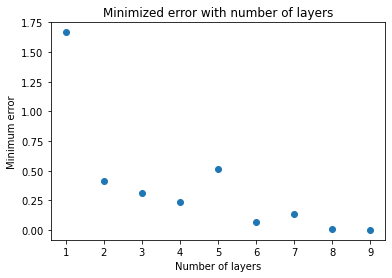

In [59]:
from matplotlib.ticker import MaxNLocator


plt.scatter(list_nlayers, min_e)
plt.xlabel("Number of layers",)
plt.ylabel("Minimum error")
plt.title("Minimized error with number of layers")
plt.show()

For the plot above, we do notice that as we increase the number of layers, the minimum error do decrease as we would expect from providing a large number of variational parameters.

In [60]:
#Increased number of iterations i.e. 1000 but total layers capped at 8
highest_nlayers=8
min_e=[]
list_nlayers=list(range(1,highest_nlayers))
for Num_layers in list_nlayers:
    print(Num_layers)
    
    #The initialization is chosen randomly and does vary as we change number of layers
    
    theta_par_array=np.random.uniform(0,2*np.pi,8*Num_layers)

    bnds = [(0., 2*np.pi)]*8*Num_layers
    
    out=minimize(Objective_fn, x0=theta_par_array, args=Num_layers,  bounds=bnds, options={'maxiter':1000}, tol=1e-6)
    print(out.fun)
    min_e.append(out.fun)
    

1
0.7554607850496968
2
0.4183540003453945
3
0.7038745026229984
4
0.747506623529736
5
0.06531489616390015
6
0.03297104051125635


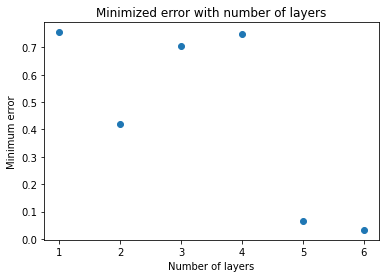

In [62]:
from matplotlib.ticker import MaxNLocator

dd
plt.scatter(list_nlayers, min_e)
plt.xlabel("Number of layers",)
plt.ylabel("Minimum error")
plt.title("Minimized error with number of layers")
plt.show()
